## Setup

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Code to visualize the execution graph in the jupyter notebook
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    

In [4]:
import tensorflow as tf

In [5]:
def plot_image(image,title=None):
    plt.figure()
    plt.imshow(image, cmap="gray", interpolation="nearest")
    if title is not None:
        plt.title(title)
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={X:np.reshape(stimuli,[1,784],order='F')})
    plotNNFilter(units)

# visualize convolution activations
def plotNNFilter(units):
    filters = units.shape[3]
    #print (filters)
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
    

# visualize convolution kernels
def plotConvLayerWeights(conv_layer_name, sess):
    kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, conv_layer_name)[0]
    #print (kernel)
    weights = sess.run(kernel)
    #print (weights)
    print(kernel.shape)
    
    n_filters = int(kernel.shape[3])
    n_base_layers = int(kernel.shape[2])
    plt.figure(figsize=(20,20))
    for j in range(n_base_layers):
        for i in range(n_filters):
            plt.subplot(n_base_layers, n_filters, j * n_filters + i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(weights[:,:,j,i].reshape(kernel.shape[0],kernel.shape[1]), cmap='gray', interpolation='nearest')
            plt.title(str(i+1))

## Load MNIST

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Select 1459 and 023678 from MNIST

Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.


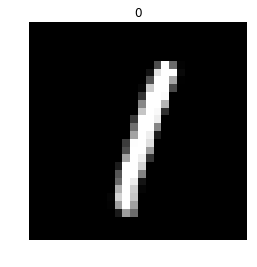

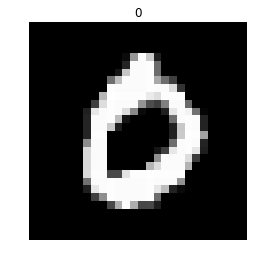

In [7]:
def prepare_data():
    global  dataset_1459_train, \
            dataset_023678_train, \
            X_1459_train, \
            y_1459_train, \
            X_1459_test, \
            y_1459_test, \
            X_023678_test, \
            y_023678_test, \
            X_023678_train, \
            y_023678_train
    mask_1459_train = np.logical_or.reduce([mnist.train.labels == v for v in [1,4,5,9]])
    mask_1459_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [1,4,5,9]])
    X_1459_train = np.compress(np.array(mask_1459_train), mnist.train.images, axis=0)
    #print(X_1459_train)
    _, y_1459_train = np.unique(mnist.train.labels[mask_1459_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_1459_train = tf.contrib.data.Dataset.from_tensor_slices((X_1459_train,y_1459_train))
    
    X_1459_test = np.compress(np.array(mask_1459_test), mnist.test.images, axis=0)
    _, y_1459_test = np.unique(mnist.test.labels[mask_1459_test], return_inverse=True)
    
    mask_023678_train = np.logical_or.reduce([mnist.train.labels == v for v in [0,2,3,6,7,8]])
    mask_023678_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [0,2,3,6,7,8]])
    X_023678_train = np.compress(np.array(mask_023678_train), mnist.train.images, axis=0)
    _, y_023678_train = np.unique(mnist.train.labels[mask_023678_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_023678_train = tf.contrib.data.Dataset.from_tensor_slices((X_023678_train,y_023678_train))
    #print(dataset_023678_train)

    X_023678_test = np.compress(np.array(mask_023678_test), mnist.test.images, axis=0)
    _, y_023678_test = np.unique(mnist.test.labels[mask_023678_test], return_inverse=True)
    #print(y_023678_train[0])

prepare_data()

# for example
plot_image(X_1459_test[2].reshape(28,28),title=y_1459_test[2])
plot_image(X_023678_test[2].reshape(28,28),title=y_023678_test[2])

# Convolutional Network

### Construct Graph

In [35]:
height = 28
width = 28
channels = 1
n_inputs = height * width
n_outputs = 4

reset_graph()
prepare_data()

# The random seed that defines initialization.
#SEED = 42

conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, channels, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=42))

conv1_biases = tf.Variable(tf.zeros([32])) # Bias variable

conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=42))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64])) # Bias vairable for the next layer

#inputs layer
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels]) # Reshaped image
    y = tf.placeholder(tf.int32, shape=[None], name="y")

with tf.name_scope("conv"):
    conv1 = tf.layers.conv2d(X_reshaped, kernel_size=[3, 3],filters=4, strides=1,activation=tf.nn.relu,padding='SAME')
    conv1 = tf.layers.dropout(conv1, rate=0.1)
    # Bias and rectified linear non-linearity.
    #relu = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
    #pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(conv1, kernel_size=[3, 3],filters=8, strides=2,activation=tf.nn.relu,padding='SAME')
    conv2 = tf.layers.dropout(conv2, rate=0.1)
    #relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
    

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, [-1, 7 * 7 * 8])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, 128, name="fc1", activation=tf.nn.relu)
    fc1 = tf.layers.dropout(fc1, rate=0.1)

with tf.name_scope("fc2"):
    fc2 = tf.layers.dense(fc1, 64, name = "fc2", activation = tf.nn.relu)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc2,4, name = "logits",activation = tf.nn.relu )
    Y_proba = tf.nn.softmax(logits, name = "Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### Train 1459

In [36]:
n_epochs = 5
batch_size = 10
LossV = []

print("Training...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_1459_train.batch(batch_size)

    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_1459_train, y: y_1459_train})
        acc_test = accuracy.eval(feed_dict={X: X_1459_test, y: y_1459_test})
        loss_val, inferred = sess.run([loss, Y_proba], feed_dict={X: X_1459_test, y: y_1459_test})
        LossV.append(loss_val)
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test, "Loss Value:" , loss_val)        
    print("Finished training")

    print("Saving...")
    save_path = saver.save(sess, "./my_model_1459.ckpt")
        
    # for example
    #inferred = sess.run(Y_proba, feed_dict={X: [X_1459_test[0]]})
    #plot_image(X_1459_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_1459_test[0]))

Training...
0 Train accuracy: 0.982852 Test accuracy: 0.98656 Loss Value: 0.404372
1 Train accuracy: 0.985908 Test accuracy: 0.989298 Loss Value: 0.356043
2 Train accuracy: 0.995941 Test accuracy: 0.996018 Loss Value: 0.353059
3 Train accuracy: 0.993205 Test accuracy: 0.992036 Loss Value: 0.362952
4 Train accuracy: 0.998085 Test accuracy: 0.99776 Loss Value: 0.350461
Finished training
Saving...


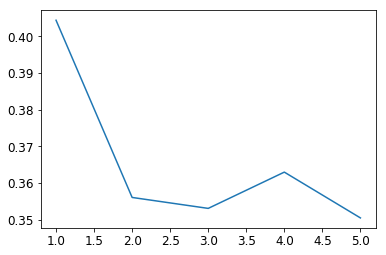

In [37]:
X = [1,2,3,4,5]
plt.plot(X, LossV)

### Build the graph for 023678

In [38]:
reset_graph()
prepare_data()

# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")

# reuse the inputs (X,y)
X = tf.get_default_graph().get_tensor_by_name("inputs/X:0")
y = tf.get_default_graph().get_tensor_by_name("inputs/y:0")
# reuse the FC1 layer
fc1 = tf.get_default_graph().get_tensor_by_name("fc1/fc1/Relu:0")
# reuse the FC2 layer
fc2_reuse = tf.get_default_graph().get_tensor_by_name("fc2/fc2/Relu:0")

# continue the 023678 graph from FC2...
with tf.name_scope("fc2_023678"):
    fc2 = tf.layers.dense(fc1,64,name="fc2_023678", activation = tf.nn.relu)

with tf.name_scope("softmax_023678"):
    logits = tf.layers.dense(fc2, 6, name="output_023678",activation = tf.nn.relu)
    Y_proba = tf.nn.softmax(logits, name="Y_proba_023678")

with tf.name_scope("train_023678"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(name="adam_023678")
## try to freeze everything but fc2, softmax
    #train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="fc2_023678|softmax_023678")
    #training_op = optimizer.minimize(loss, var_list=train_vars)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval_023678"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_023678"):
    init = tf.global_variables_initializer()
    new_saver = tf.train.Saver()

## Train transferred 023678

In [39]:
n_epochs = 8
batch_size = 10
LossV = []
print("Training 023678...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_023678_train.batch(batch_size)

    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
#     saver.restore(sess, "./my_model_1459.ckpt")
    
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                #print(y_batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_023678_train, y: y_023678_train})
        acc_test = accuracy.eval(feed_dict={X: X_023678_test, y: y_023678_test})
        loss_val, inferred = sess.run([loss, Y_proba], feed_dict={X: X_1459_test, y: y_1459_test})
        LossV.append(loss_val)
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test, "Loss Value:" , loss_val)
        
    print("Finished training")
    
    

    # for example
    #inferred = sess.run(Y_proba, feed_dict={X: [X_023678_test[0]]})
    #plot_image(X_023678_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_023678_test[0]))

Training 023678...
0 Train accuracy: 0.977535 Test accuracy: 0.974256 Loss Value: 5.07361
1 Train accuracy: 0.986726 Test accuracy: 0.985456 Loss Value: 5.62867
2 Train accuracy: 0.990687 Test accuracy: 0.984788 Loss Value: 6.17814
3 Train accuracy: 0.994739 Test accuracy: 0.988967 Loss Value: 6.23727
4 Train accuracy: 0.992048 Test accuracy: 0.983785 Loss Value: 6.37428
5 Train accuracy: 0.99492 Test accuracy: 0.987128 Loss Value: 6.74179
6 Train accuracy: 0.991443 Test accuracy: 0.983283 Loss Value: 6.7472
7 Train accuracy: 0.996855 Test accuracy: 0.987295 Loss Value: 6.44959
Finished training


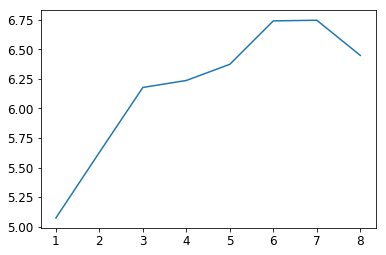

In [40]:
x = [1,2,3,4,5,6,7,8]
plt.plot(x, LossV)

## Visualize the Feature Maps
The following code is useful to look into the activations of convolutional and pooling layers

In [22]:
import math


with tf.Session() as sess:

    saver.restore(sess, "./my_model_1459.ckpt")
    #getActivations(tf.get_default_graph().get_tensor_by_name("correct:0"), X_1459_test[0])

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt


### Visualize the convolution kernels

In [23]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_1459.ckpt")
    
    #plotConvLayerWeights(,sess)

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt


## Show the Execution Graph

In [18]:
reset_graph()

# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")

show_graph(tf.get_default_graph())